# Endpoint Regressor Validation

Validate a trained endpoint regressor:
- Load model from checkpoint
- Load validation data
- Generate predictions (all quantiles)
- Plot regression diagnostics and Euclidean errors

**Quantiles:** The model outputs three quantiles per coordinate: q16 (~-1σ), q50 (median), q84 (~+1σ). All plots are labeled with the corresponding quantile.


In [1]:
import torch
from pathlib import Path
from datetime import datetime

from pioneerml.zenml import utils as zenml_utils
from pioneerml.metadata import MetadataManager
from pioneerml.data import load_hits_and_info
from pioneerml.training.datamodules import EndpointDataModule
from pioneerml.evaluation.plots import (
    plot_regression_diagnostics,
    plot_euclidean_error_histogram,
)

PROJECT_ROOT = zenml_utils.find_project_root()
metadata_manager = MetadataManager(root=PROJECT_ROOT)

print(f"Project root: {PROJECT_ROOT}")


Project root: /home/jack/python_projects/pioneerML


## List Available Checkpoints

In [2]:
checkpoints = metadata_manager.print_checkpoints("EndpointRegressor")
if not checkpoints:
    raise ValueError("No checkpoints found for EndpointRegressor")

print(f"Using checkpoint: {checkpoints[0]['checkpoint_path'].name}")


Found 1 checkpoint(s):
  1. endpointregressor_20260103_124027_endpoint_optuna_pipeline-2026_01_03-12_33_04_260918_state_dict.pt
     Timestamp:     20260103_124027
     Run:           endpoint_optuna_pipeline-2026_01_03-12_33_04_260918
     Architecture:  hidden=128, heads=8, layers=4, dropout=0.18402435315850102
Using checkpoint: endpointregressor_20260103_124027_endpoint_optuna_pipeline-2026_01_03-12_33_04_260918_state_dict.pt


## Load Model

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, metadata = metadata_manager.load_model(
    "EndpointRegressor",
    index=0,
    device=device,
)

print(f"Model loaded successfully on {device}")
print(f"  Checkpoint: {checkpoints[0]['checkpoint_path'].name}")
print(f"  Timestamp: {metadata.timestamp}")
print(f"  Run: {metadata.run_name or 'unknown'}")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")


Model loaded successfully on cuda
  Checkpoint: endpointregressor_20260103_124027_endpoint_optuna_pipeline-2026_01_03-12_33_04_260918_state_dict.pt
  Timestamp: 20260103_124027
  Run: endpoint_optuna_pipeline-2026_01_03-12_33_04_260918
  Parameters: 1,069,862


## Load Validation Data

In [4]:
hits_pattern = str(Path(PROJECT_ROOT) / "data" / "raw_hits_info" / "hits_batch_*.npy")
info_pattern = str(Path(PROJECT_ROOT) / "data" / "raw_hits_info" / "group_info_batch_*.npy")

validation_groups = load_hits_and_info(
    hits_pattern=hits_pattern,
    info_pattern=info_pattern,
    max_files=1,
    limit_groups=None,
    min_hits=2,
    include_hit_labels=False,
    verbose=True,
)
validation_groups = [g for g in validation_groups if getattr(g, "true_start", None) is not None and getattr(g, "true_end", None) is not None]
print(f"Loaded {len(validation_groups)} groups for validation")

datamodule = EndpointDataModule(
    records=validation_groups,
    batch_size=128,
    num_workers=0,
    val_split=0.0,
    test_split=0.0,
    seed=42,
)
datamodule.setup(stage="fit")

val_dataset = datamodule.val_dataset or datamodule.train_dataset
if val_dataset is None:
    raise ValueError("No validation dataset available")

print(f"Validation dataset size: {len(val_dataset)}")


Limiting to 1 files (from 11 total files found, max_files=1)
Limiting to 1 files (from 11 total files found, max_files=1)
Loaded 9984 groups from 1 file pairs


Loaded 9984 groups for validation
Validation dataset size: 9984


## Generate Predictions (all quantiles)

In [5]:
from torch_geometric.loader import DataLoader

quantiles = [0.16, 0.50, 0.84]
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0)

all_preds, all_tgts = [], []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)
        preds = model(batch)    # [B, 2, 3, Q]
        tgts = batch.y          # [B, 2, 3, Q] (targets repeated across quantiles)

        preds = preds.squeeze()
        tgts = tgts.squeeze()
        if tgts.dim() == 5:
            tgts = tgts.squeeze(1)
        if preds.dim() == 3:
            preds = preds.unsqueeze(-1)
            tgts = tgts.unsqueeze(-1)

        all_preds.append(preds.cpu())
        all_tgts.append(tgts.cpu())

predictions = torch.cat(all_preds, dim=0)   # [N, 2, 3, Q]
targets = torch.cat(all_tgts, dim=0)        # [N, 2, 3, Q]

predictions_flat = predictions.view(predictions.size(0), -1)
targets_flat = targets.view(targets.size(0), -1)

# Median (q50) for Euclidean error plots
preds_mid = predictions[..., 1]
tgts_mid = targets[..., 1]
start_pred, end_pred = preds_mid[:, 0, :], preds_mid[:, 1, :]
start_true, end_true = tgts_mid[:, 0, :], tgts_mid[:, 1, :]

print(f"Predictions shape: {predictions.shape}")
print(f"Targets shape: {targets.shape}")
print(f"Flattened shapes: preds={predictions_flat.shape}, targets={targets_flat.shape}")


Predictions shape: torch.Size([9984, 2, 3, 3])
Targets shape: torch.Size([9984, 2, 3, 3])
Flattened shapes: preds=torch.Size([9984, 18]), targets=torch.Size([9984, 18])


## Regression Diagnostics (all quantiles)

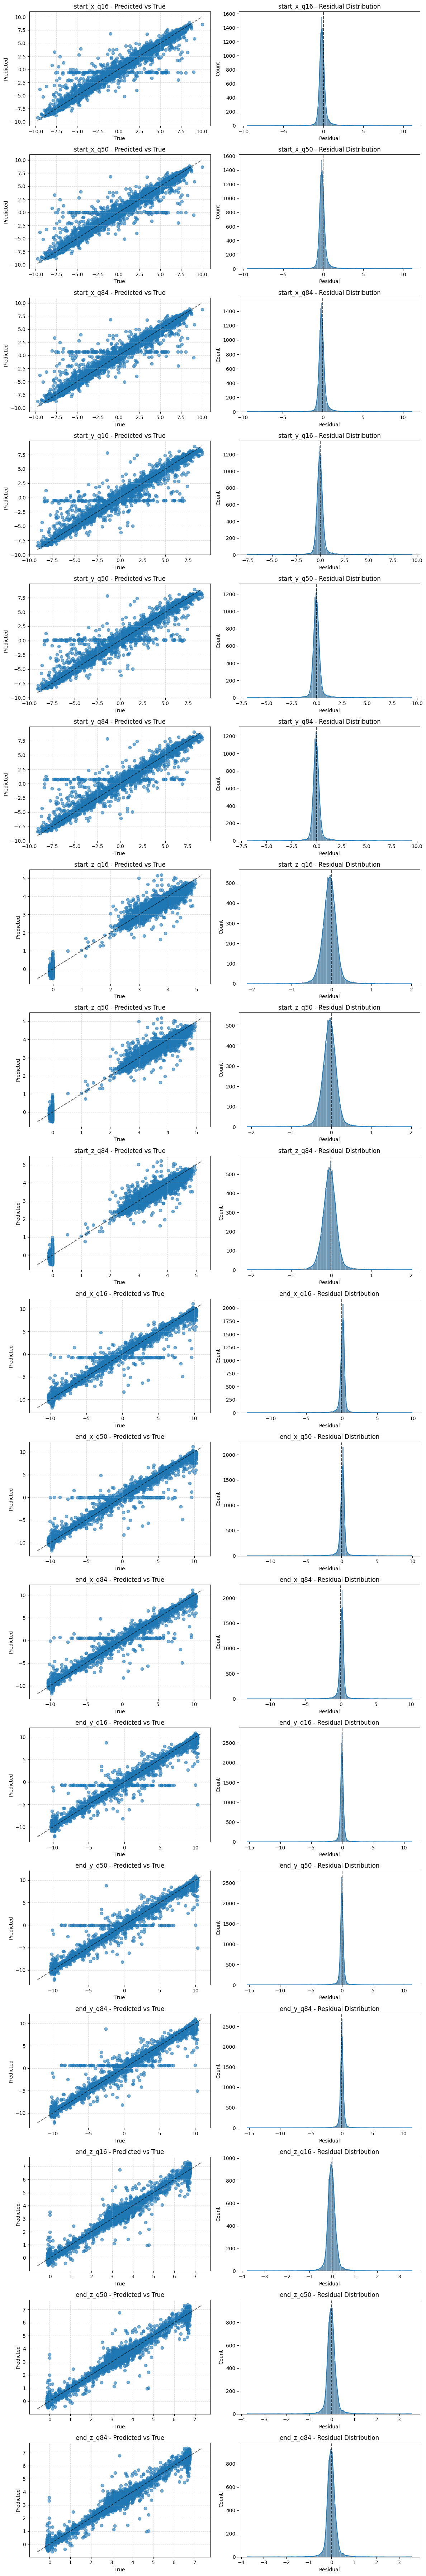

In [6]:
component_names = []
labels = ["start", "end"]
coord_labels = ["x", "y", "z"]
quant_labels = ["q16", "q50", "q84"]
for le in labels:
    for lc in coord_labels:
        for lq in quant_labels:
            component_names.append(f"{le}_{lc}_{lq}")

plot_regression_diagnostics(
    predictions=predictions_flat,
    targets=targets_flat,
    component_names=component_names,
    show=True,
)


## Euclidean Error (Median Quantile)

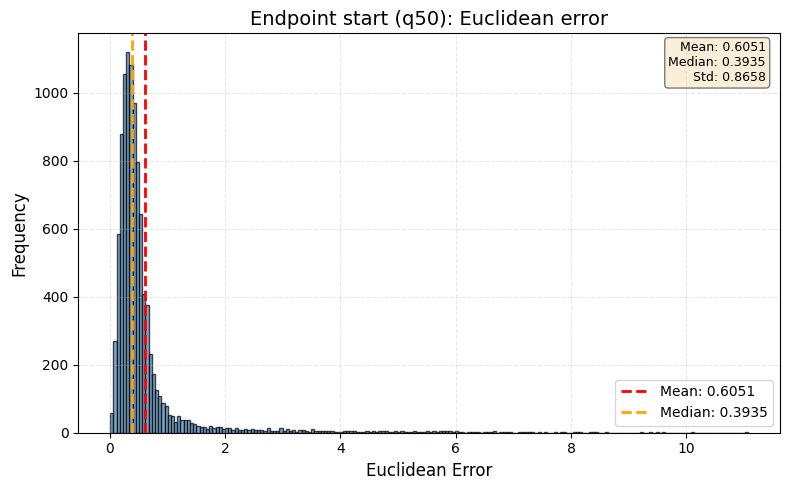

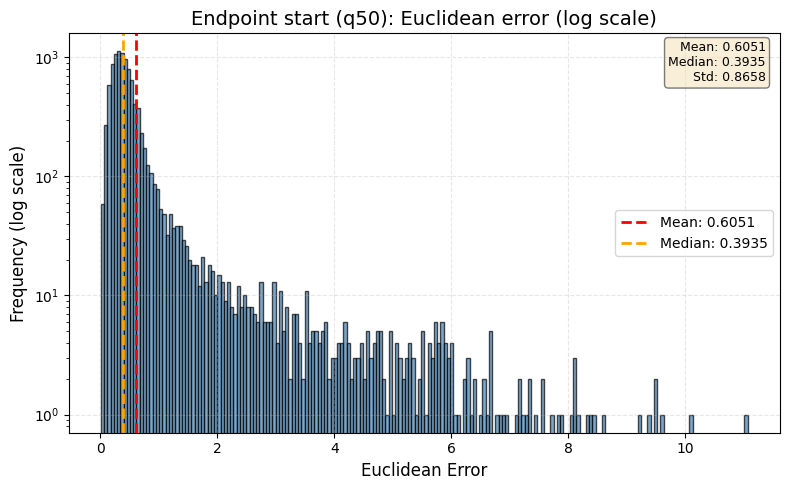

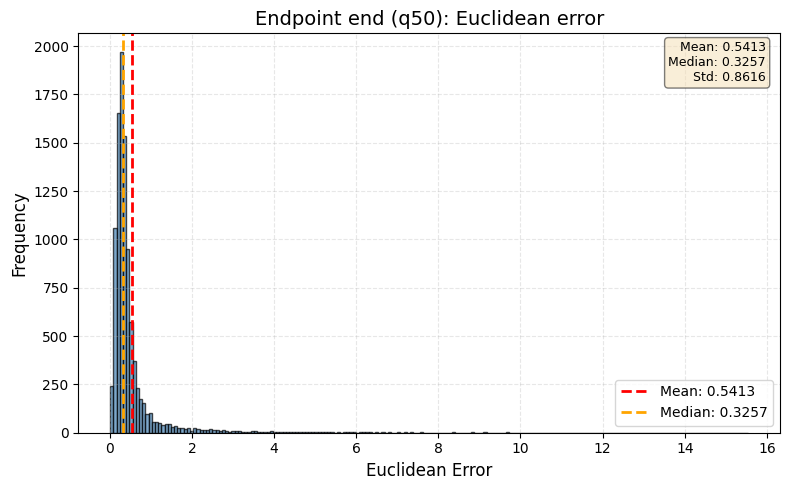

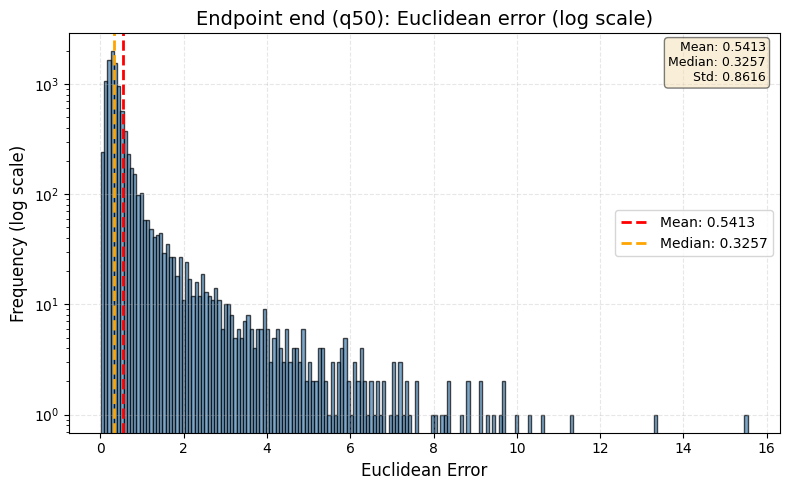

In [7]:
# Start point
plot_euclidean_error_histogram(
    predictions=start_pred,
    targets=start_true,
    log_scale=False,
    title="Endpoint start (q50): Euclidean error",
    show=True,
)
plot_euclidean_error_histogram(
    predictions=start_pred,
    targets=start_true,
    log_scale=True,
    title="Endpoint start (q50): Euclidean error (log scale)",
    show=True,
)

# End point
plot_euclidean_error_histogram(
    predictions=end_pred,
    targets=end_true,
    log_scale=False,
    title="Endpoint end (q50): Euclidean error",
    show=True,
)
plot_euclidean_error_histogram(
    predictions=end_pred,
    targets=end_true,
    log_scale=True,
    title="Endpoint end (q50): Euclidean error (log scale)",
    show=True,
)
